This notebook was created by Alissa Ostapenko (aostapenko@wpi.edu) for WPI Army Research Laboratory.   
Date: 05/12/2020.

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Flowability Classification
Here you will learn how to run a basic Classification model (predicting specific flowability classes) using correlation-matrix based feature selection and Decision Trees. This notebook is based off of the Augmented Microtrac Data (with Density, MinSize, and MaxSize), but these columns can be filtered out during the Data Preprocessing phase.

This notebook features multiclass classification with 3 classes: 
* **0 (LowFlow)** || Ti-5Al-5V-5Mo-3Cr (0-75), Ti-Nb (0-63), Ti-Nb (64-150)
* **1 (MediumFlow)** || SS-17-4 (64-150), SS-17-4 (10-45)
* **2 (HighFlow)** || Ti-Nb-Zr (0-63), Ti-Nb-Zr (64-150),

In [2]:
from DataPreprocessor import DataPreprocessor 
from TrainTestPipeline import TrainTestPipeline
import pandas as pd

## Data Preprocessing 
Data Preprocessing is done by the *DataPreprocessor* class. It relies on helper functions in the *data_proprocessing.py* file to:
 - Transform data to make it follow a Gaussian distribution, and z-score normalize the data
 - Gets the transformed data and labels (saves to an AllData.csv file to speed up processing
 - Updates flow numbers and flow classes if they change (and updates AllData.csv as necessary)
 - Computes correlations (linear and nonlinear) between variables, and can visualize these correlations.
 
 
**New folders/files you should expect after all data preprocessing, if running this notebook for the first time:**   
 **1.**   New *{Material} {SizeRange} Particles_cleaned.csv* files in your original raw data folder which remove micron symbols from the original raw data files from microtrac (Python's CSV reader cannot parse micron symbols!)  
 **2.**   A new folder, *{RawData}\_transformed* with cleaned, Gaussian, standardized data (one csv file for each sample)  
 **3.**   An *AllData.csv* file with transformed data for all samples   
 **4.**  A *nonlinear_correlation.pkl* file if using MIC-based correlation   

### Step 1: Initialize a DataPreprocessor Object 


Specify the:
 - **Data Folder** with raw, unprocessed CSV files of samples data (e.g., Ti-Nb-Zr (0-63)
     Particles.csv is in here)
 - **Flow Values Excel Sheet** with the target flow values and target flow classes. Specify flow classes in the 'FlowClass' column. Use only positive integers from 0 onwards.  
 This file also includes the Augmented Density (AugDensity) that the materials science team provided for each sample.


**IMPORTANT:**   
* In the Flow Values Excel sheet, do **not** type outside of the colored rows, especially in rows below the data. If adding more data, make sure to follow the same format as in the sheet.     
* Make sure the names of your samples, and size ranges of the samples, match **exactly** with how they are named in each raw Excel data sheet in your data folder.  

In [3]:
data_folder = '../RawData'
flow_values_excel = '../TrueFlowValues_.xlsx'
dp = DataPreprocessor(data_folder, flow_values_excel)

### Step 2: Prepare the Data 
Files/folders \#1-3 above will be created in this step. 

Use the *prepare_df()* method to create files/folders \#1-3, if they have not been created already.

*Note: This may take a few minutes the first time you run it.*

### Step 3: Feature Selection with a Correlation Matrix
```method```  Specify the **method** ('pearson' or 'mic') to run linear or nonlinear correlation, respectively. Default is 'pearson'.   
```threshold```  Specify a **threshold** (default is 0.8).  
```heldout_cols```  Specify parameter names you want to **hold out** (to use all parameters, do not specify anything). 

*For example, if you want to ignore the augmented features Density, MinSize, and MaxSize, you will do:*
```
heldout_cols = ['Density', 'MinSize', 'MaxSize'] 
```

This step returns a **numpy matrix of the data (X-values)**, as well as a **list of the uncorrelated columns** kept for prediction. **File \#4** will be created if you run 'mic' correlation.

*Note: Running 'mic' correlation may take a few minutes the first time you run it.*

In [4]:
success = dp.prepare_df()
assert success

In [5]:
# Pearson-correlation, full dataset with augmented features
x_filt, columns = dp.get_feature_selection_x(method='pearson', threshold = 0.8, 
                                            heldout_cols = None)

Feature columns used: ['Da', 'Sphericity', 'Ellipse Ratio', 'Concavity', 'Convexity', 'Extent', 'Transparency', 'Curvature', 'L/W Ratio', 'Fiber Length', 'MinSize', 'Density']


In [6]:
# MIC correlation, full dataset with augmented features 
x_filt_mic, columns_mic = dp.get_feature_selection_x(method='mic', threshold = 0.8, 
                                            heldout_cols = None)

Feature columns used: ['Da', 'Sphericity', 'Compactness', 'Ellipse Ratio', 'Solidity', 'Convexity', 'Extent', 'Transparency', 'Curvature', 'MaxSize']


#### Optional: Steps to visualize the linear (and nonlinear) correlation matrices:
We can use the *DataPreprocessor*'s ```visualize_correlation(...)``` function to save the Pearson (or MIC) based correlation matrices to a .pdf.  

Specify the following parameters: 
* ```output_file``` Specify a **.pdf** filename to save your results to. 
* ```method``` Specify the method (either *'pearson'* or *'mic'*) (default: 'pearson').
* ```threshold``` Specify the threshold (default: 0.8).

If you run the cell below, you should see 2 new *.pdf* files:
* *PearsonCorrelation_for_Augmented_Data.pdf*
* *MICCorrelation_for_Augmented_Data.pdf*

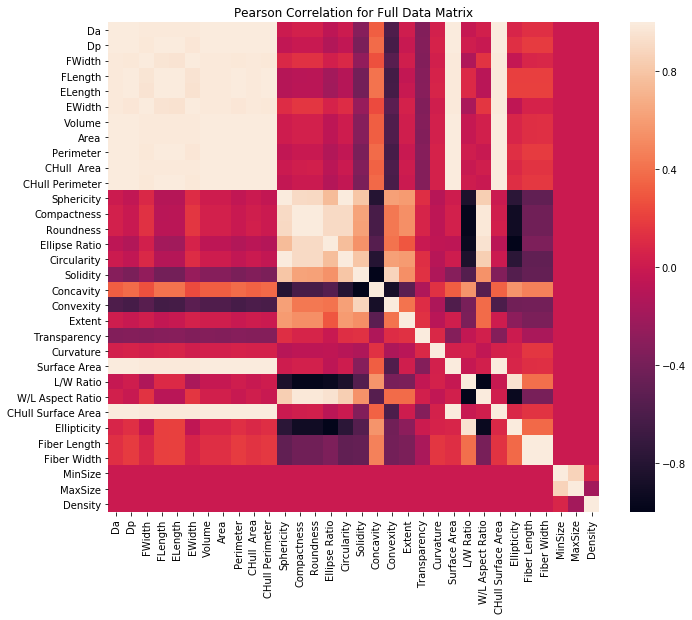

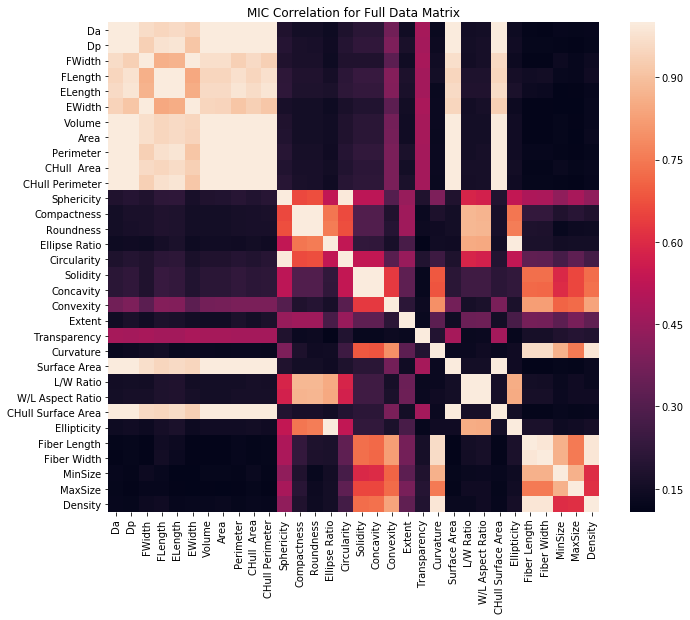

In [7]:
# Pearson correlation with a threshold of 0.8
dp.visualize_correlation(output_file = 'PearsonCorrelation_for_Augmented_Data.pdf')
# MIC-correlation with a threshold of 0.8
dp.visualize_correlation(output_file = 'MICCorrelation_for_Augmented_Data.pdf', 
                        method = 'mic', threshold = 0.8)


### Step 4: Prepare the Processed Data for Training and Testing
Use the *DataPreprocessor* to grab the:
* **Classification Target Values**
* **List of Sample Names** corresponding to each row of the X-data (*x_filt* and *x_filt_mic* above). 

Each sample name is a material and size range.  


In [8]:
y_class = dp.get_classification_y()
all_samples = dp.get_samples()

## Training and Testing  
Model training and testing is done by the *TrainTestPipeline* class. It relies on helper functions in the *training_utils.py* and *test_utils.py* files to:
 - Split the data into training and test sets (5 samples are used for train, 3 are held out)
 - Train a (DecisionTreeClassifier) model and test it 
 - Visualize the model test performance and save it to a .pdf file 
 - Visualize the internals of the trained DecisionTreeClassifier, save them to a .png file 
 - Save feature importance rankings to a .csv file

### Step 5: Initialize a TrainTestPipeline 
A TrainTestPipeline comprises of 4-5 parameters:  
```x_data``` Input the **X-data object** (*x_filt* or *x_filt_mic*).  
```y_data```Input the **Regression target values** (*y_reg*).    
```all_samples```Input the **List of Sample Names** (*all_samples*).  
```model_name```Specify the **model type** ("DecisionTreeRegressor").   
* See the OneDrive folder for a full list of supported models.  

```heldout_samples```  Specify a list of **held-out test samples** (optional).   
In this example, we will use our best train set to train our DecisionTree. The heldout samples are: 
* SS-17-4 (10-45)
* SS-17-4 (64-150) 
* Ti-5Al-5V-5Mo-3Cr (0-75)


*By default, ```heldout_samples``` is 'random', meaning that 3 random samples from the 8 samples will be selected for testing.* 

In [9]:
# DecisionTreeRegressor trained on the best train set for augmented data 
# filtered by Pearson correlation
pipeline = TrainTestPipeline(x_data = x_filt, y_data = y_class, all_samples = all_samples, 
                             model_name = 'DecisionTreeClassifier', 
                             heldout_samples = ['SS-17-4 (10-45)', 
                                                'SS-17-4 (64-150)', 
                                                'Ti-5Al-5V-5Mo-3Cr (0-75)'])

### Step 6: Split Data, Train, and Test a Model
To train our DecisionTreeRegressor on the Pearson correlation matrix filtered features (Density, MinSize, MaxSize are included) we will use:  
```
do_train_test(...)
```

We will use Leave One Out cross-validation to test our cross-validation accuracy as we learn from the 5 train samples.  

LOOCV runs for 5 rounds; each train sample has a chance to be a test sample. The final model is trained on all 5 samples.  

With ```cv = False```, we directly train on the 5 samples without looking at cross-validation scores.

In [10]:
tr_test_ = pipeline.do_train_test(cv = True)

Train Set Proportion: 0.739957
Test Set Proportion: 0.260043
Train Set Samples: ['Inconel 718 (0-63)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)']
Test Set Samples: ['SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)']
Training on ['Inconel 718 (0-63)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)']
Validating on Ti-Nb-Zr (64-150)
RMSE Validation: 0.00
Training on ['Inconel 718 (0-63)' 'Ti-Nb (0-63)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)']
Validating on Ti-Nb (64-150)
RMSE Validation: 0.00
Training on ['Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)']
Validating on Inconel 718 (0-63)
RMSE Validation: 1.00
Training on ['Inconel 718 (0-63)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (64-150)']
Validating on Ti-Nb-Zr (0-63)
RMSE Validation: 1.00
Training on ['Inconel 718 (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)']
Validating on Ti-Nb (0-63)
RMSE Validation: 0.00
Average Validation Score: 0.40
Test RMSE 0.000

### Step 7: Visualizing Model Performance, Tree Structure, and Feature Importances
We can save a .pdf visualizing our model's predictions on the heldout test data above: 


Our Pipeline has a built-in function ```visualize_performance(...)``` for visualizing test performance.

#### Steps to visualize our test performance:
1. ```model``` Get the trained model from our *tr_test_* object above.
2. ```train_test_split``` Get the data_split used for training and test, again from *tr_test_* above.
2. ```output_file``` Specify a **.pdf** filename to which the pdf of the test performance will be saved.

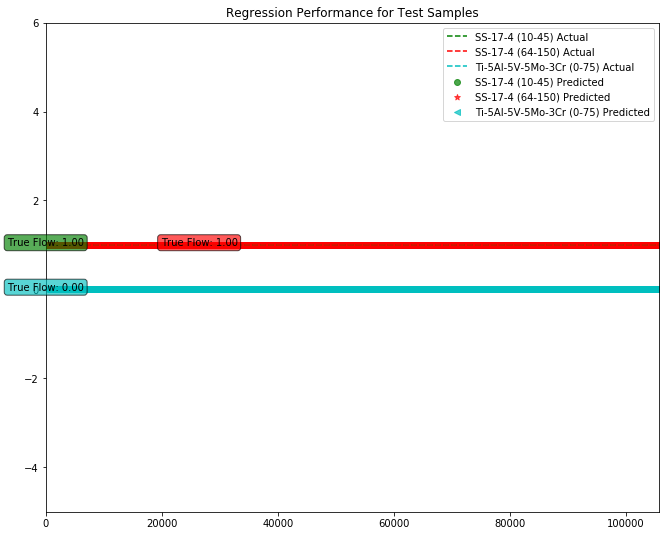

In [11]:
#visualize results
model_ = tr_test_['model']
data_split = tr_test_['train_test_split']
pipeline.visualize_performance(model = model_, train_test_split = data_split, 
                               output_file = 'DTClassifyViz_Pearson_WithAugmentedData.pdf')

Check your files. There should now be a *DTClassifyViz_Pearson_WithAugmentedData.pdf* saved visualizing the predictions (via markers) versus true mean flow values (dashed-lines). Each sample is color-coded.

#### Steps to visualize the internals of our tree, and see feature importance rankings:
We will use a function called ```trained_tree_to_png(...)```. It requires the following:
1. ```model``` Get the trained model from our *tr_test_* object above.
2. ```feature_names``` List of names of the *columns* we used to train our model. We got these columns after running **Step 2**.
3. ```all_y_data``` **(New) Different from regression**... To better visualize classes, pass a list of strings (class names), as shown below. 
4. ```outfile_name``` Specify a **.png** filename to which to save the tree to. 

In this function, the DecisionTree's feature importance rankings are saved to a csv file named

```outfile_name``` *\_feature\_importances.csv* 

**New: Different from regression**  
```class_names``` : A list, in increasing order from Class 0 to Class x, of (x+1) strings (class names)  
In this example, we just did a binary classification (whether the flow was greater than 15 or not, so we have two class names: "LowFlow" and "HighFlow". These names are arbitrary. 

In [12]:
class_names = []
for c in y_class:
    names = {0: "LowFlow", 1: "MediumFlow", 2: "HighFlow"}
    class_names.append(names[c])
    
pipeline.trained_tree_to_png(model_, feature_names=columns, 
                             all_y_data = class_names, 
                             outfile_name = 'ClassifyBestTrainSetTree.png')


Feature Importances
     feature_name  score
11        Density    1.0
0              Da    0.0
1      Sphericity    0.0
2   Ellipse Ratio    0.0
3       Concavity    0.0
4       Convexity    0.0
5          Extent    0.0
6    Transparency    0.0
7       Curvature    0.0
8       L/W Ratio    0.0
9    Fiber Length    0.0
10        MinSize    0.0


Check your files. There should now be a *BestTrainSetTree_WithAugmentedData.png* saved visualizing the internals of each tree. There should also be a *BestTrainSetTree_WithAugmentedData_feature_importances.csv* file with feature importances, as printed in when running the cell above.

In [13]:
features_ = pd.read_csv('ClassifyBestTrainSetTree_feature_importances.csv')
features_.head(10)

,feature_name,score
0,Density,1.0
1,Da,0.0
2,Sphericity,0.0
3,Ellipse Ratio,0.0
4,Concavity,0.0
5,Convexity,0.0
6,Extent,0.0
7,Transparency,0.0
8,Curvature,0.0
9,L/W Ratio,0.0


## Finding the Best Train/Test Set
Use the TrainTestPipeline's ```exhaustive_train(...)``` method to run all 56 combinations of train/test set ups.   
Specify an ```outfile_name```, a *.csv* file to which to save test results. There will be 56 rows; the 3 samples held out for testing will be indicated in each row as well as the F1-score achieved by the model for that train-test split.

After running this, you should see a new *ClassifyExhaustiveTrainTest.csv* file. 

In [14]:
pipeline.exhaustive_train('ClassifyExhaustiveTrainTest.csv')

Combo ['SS-17-4 (10-45)', 'Ti-Nb-Zr (0-63)', 'Inconel 718 (0-63)'], 1 of 56
Train Set Proportion: 0.384111
Test Set Proportion: 0.615889
Train Set Samples: ['SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (64-150)']
Test Set Samples: ['Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'Ti-Nb-Zr (0-63)']
Training on ['SS-17-4 (64-150)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (64-150)']
Validating on Ti-5Al-5V-5Mo-3Cr (0-75)
RMSE Validation: 0.00
Training on ['SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)'
 'Ti-Nb-Zr (64-150)']
Validating on Ti-Nb (64-150)
RMSE Validation: 0.00
Training on ['Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (64-150)']
Validating on SS-17-4 (64-150)
RMSE Validation: 1.00
Training on ['SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)']
Validating on Ti-Nb-Zr (64-150)
RMSE Validation: 2.00
Training on ['SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (64-150)'
 'T

Training on ['Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)']
Validating on Ti-Nb-Zr (64-150)
RMSE Validation: 0.00
Training on ['Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)']
Validating on Ti-5Al-5V-5Mo-3Cr (0-75)
RMSE Validation: 0.00
Training on ['Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (64-150)']
Validating on Ti-Nb-Zr (0-63)
RMSE Validation: 0.00
Training on ['Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)']
Validating on Ti-Nb (0-63)
RMSE Validation: 0.00
Training on ['Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)']
Validating on Ti-Nb (64-150)
RMSE Validation: 0.00
Average Validation Score: 0.00
Test RMSE 1.000000
Combo ['SS-17-4 (10-45)', 'Inconel 718 (0-63)', 'Ti-Nb-Zr (64-150)'], 9 of 56
Train Set Proportion: 0.590155
Test Set Proportion: 0.409845
Train Set Samples: ['SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)'
 

Training on ['Inconel 718 (0-63)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-Nb-Zr (0-63)']
Validating on Ti-Nb-Zr (64-150)
RMSE Validation: 0.00
Training on ['Inconel 718 (0-63)' 'SS-17-4 (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)']
Validating on Ti-5Al-5V-5Mo-3Cr (0-75)
RMSE Validation: 2.00
Average Validation Score: 1.00
Test RMSE 1.539448
Combo ['SS-17-4 (10-45)', 'SS-17-4 (64-150)', 'Ti-Nb-Zr (64-150)'], 16 of 56
Train Set Proportion: 0.734988
Test Set Proportion: 0.265012
Train Set Samples: ['Inconel 718 (0-63)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)']
Test Set Samples: ['SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-Nb-Zr (64-150)']
Training on ['Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)']
Validating on Inconel 718 (0-63)
RMSE Validation: 1.00
Training on ['Inconel 718 (0-63)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)']
Validating on Ti-Nb (0-63)
RMSE Validation: 0.00
Training on [

Train Set Proportion: 0.559662
Test Set Proportion: 0.440338
Train Set Samples: ['SS-17-4 (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (64-150)']
Test Set Samples: ['Inconel 718 (0-63)' 'SS-17-4 (64-150)' 'Ti-Nb-Zr (0-63)']
Training on ['Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (64-150)']
Validating on SS-17-4 (10-45)
RMSE Validation: 1.00
Training on ['SS-17-4 (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (64-150)']
Validating on Ti-Nb (0-63)
RMSE Validation: 0.00
Training on ['SS-17-4 (10-45)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (64-150)']
Validating on Ti-5Al-5V-5Mo-3Cr (0-75)
RMSE Validation: 0.00
Training on ['SS-17-4 (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)'
 'Ti-Nb-Zr (64-150)']
Validating on Ti-Nb (64-150)
RMSE Validation: 0.00
Training on ['SS-17-4 (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)']
Validating on Ti-Nb-Zr (64-150)
RMSE Validation: 2.00
Average Valid

Training on ['Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)']
Validating on Ti-Nb-Zr (64-150)
RMSE Validation: 2.00
Training on ['Inconel 718 (0-63)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-Nb-Zr (64-150)']
Validating on SS-17-4 (10-45)
RMSE Validation: 0.00
Training on ['Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-Nb-Zr (64-150)']
Validating on SS-17-4 (64-150)
RMSE Validation: 0.00
Training on ['SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-Nb-Zr (64-150)']
Validating on Inconel 718 (0-63)
RMSE Validation: 0.00
Average Validation Score: 0.80
Test RMSE 1.491914
Combo ['Ti-Nb-Zr (0-63)', 'SS-17-4 (64-150)', 'Ti-Nb-Zr (64-150)'], 31 of 56
Train Set Proportion: 0.702471
Test Set Proportion: 0.297529
Train Set Samples: ['Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)']
Test Set Samples: ['SS-17-4 (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)']

RMSE Validation: 2.00
Training on ['SS-17-4 (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)']
Validating on Ti-Nb-Zr (64-150)
RMSE Validation: 0.00
Average Validation Score: 0.60
Test RMSE 0.000000
Combo ['Inconel 718 (0-63)', 'Ti-Nb (0-63)', 'Ti-Nb-Zr (64-150)'], 38 of 56
Train Set Proportion: 0.519904
Test Set Proportion: 0.480096
Train Set Samples: ['SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)']
Test Set Samples: ['Inconel 718 (0-63)' 'Ti-Nb (0-63)' 'Ti-Nb-Zr (64-150)']
Training on ['SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-Nb (64-150)']
Validating on Ti-Nb-Zr (0-63)
RMSE Validation: 2.00
Training on ['SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-Nb-Zr (0-63)']
Validating on Ti-Nb (64-150)
RMSE Validation: 1.00
Training on ['SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)']
Validating on SS-17-4 (10-45)
RMSE Validation: 0.00
T

Test Set Samples: ['Inconel 718 (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (64-150)']
Training on ['SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)'
 'Ti-Nb-Zr (0-63)']
Validating on SS-17-4 (10-45)
RMSE Validation: 1.00
Training on ['SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-Nb-Zr (0-63)']
Validating on Ti-Nb (0-63)
RMSE Validation: 2.00
Training on ['SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-Nb (0-63)']
Validating on Ti-Nb-Zr (0-63)
RMSE Validation: 2.00
Training on ['SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-Nb (0-63)' 'Ti-Nb-Zr (0-63)']
Validating on Ti-5Al-5V-5Mo-3Cr (0-75)
RMSE Validation: 0.00
Training on ['SS-17-4 (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)'
 'Ti-Nb-Zr (0-63)']
Validating on SS-17-4 (64-150)
RMSE Validation: 0.00
Average Validation Score: 1.00
Test RMSE 0.000000
Combo ['Inconel 718 (0-63)', 'Ti-5Al-5V-5Mo-3Cr (0-75)', 'Ti-Nb (64-150)'], 46 of 56
Train Set Proportion: 0.777172
Test Set Proportion: 0.2228

Training on ['Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)']
Validating on SS-17-4 (64-150)
RMSE Validation: 0.00
Training on ['Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-Nb-Zr (64-150)']
Validating on Ti-Nb-Zr (0-63)
RMSE Validation: 0.00
Average Validation Score: 0.00
Test RMSE 2.000000
Combo ['SS-17-4 (64-150)', 'Ti-Nb-Zr (64-150)', 'Ti-5Al-5V-5Mo-3Cr (0-75)'], 53 of 56
Train Set Proportion: 0.913484
Test Set Proportion: 0.086516
Train Set Samples: ['Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)']
Test Set Samples: ['SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb-Zr (64-150)']
Training on ['Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'Ti-Nb (0-63)' 'Ti-Nb-Zr (0-63)']
Validating on Ti-Nb (64-150)
RMSE Validation: 0.00
Training on ['Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)']
Validating on Ti-Nb-Zr (0-63)
RMSE Validation: 2.00
Training on ['Inconel 718 (0-63)' 'SS-17-4

In [15]:
best_train_sets = pd.read_csv('ClassifyExhaustiveTrainTest.csv')
best_train_sets.head(5)

,TrainProp,TestProp,TestSample1,TestSample2,TestSample3,CrossVal RMSE,Test RMSE
0,0.384111,0.615889,SS-17-4 (10-45),Ti-Nb-Zr (0-63),Inconel 718 (0-63),0.6,0.0
1,0.458694,0.541306,Ti-Nb-Zr (0-63),Ti-Nb (0-63),SS-17-4 (64-150),1.0,0.0
2,0.922005,0.077995,SS-17-4 (64-150),Ti-5Al-5V-5Mo-3Cr (0-75),Ti-Nb (64-150),0.8,0.0
3,0.461639,0.538361,Ti-Nb-Zr (0-63),Ti-Nb (0-63),Ti-5Al-5V-5Mo-3Cr (0-75),1.0,0.0
4,0.707440,0.292560,Ti-Nb-Zr (0-63),SS-17-4 (64-150),Ti-5Al-5V-5Mo-3Cr (0-75),1.0,0.0
